# Contradictory, My dear Watson - A relation extraction task

For a any given two sentences, there are three ways they could be related: one could entail the other, one could contradict the other, or they could be unrelated. **Natural Language Inferencing** (NLI) is a popular NLP problem that involves determining how pairs of sentences (consisting of a premise and a hypothesis) are related.

Our task is to create an NLI model that assigns labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses. To make things more interesting, the train and test set include text in fifteen different languages!

About this kernel

This kernel acts as a starter kit. It gives all the essential Key insights on the given text data.

Key Takeaways

- Effective Story Telling using EDA
- Creative Feature Engineering
- Modelling

In [1]:
## Install the necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



## Data Visualisation
# from plotly.offline import iplot
# from plotly import tools
# import plotly.graph_objects as go
# import plotly.express as px
# import plotly.offline as py
# import plotly.figure_factory as ff
# py.init_notebook_mode(connected=True)
# import plotly.offline as pyo

## Data Preprocessing
import re
import nltk
from gensim.models import word2vec

## Visializing similarity of words
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

##Translation
#from googletrans import Translator


## Models
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.preprocessing import LabelEncoder

## Bert models from HuggingFace library
from transformers import BertTokenizer, TFAutoModel, AutoTokenizer
import tensorflow as tf
import keras
from tensorflow.math import softplus, tanh
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras import Input, Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Embedding, GlobalAveragePooling1D
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [3]:
train_df = pd.read_csv('../input/contradictory-my-dear-watson/train.csv')
print('Traning Data, the size of the dataset is: {} \n'.format(train_df.shape))

test_df = pd.read_csv('../input/contradictory-my-dear-watson/test.csv')

Traning Data, the size of the dataset is: (12120, 6) 



In [4]:
train_df = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/train.csv")
test_df = pd.read_csv("/kaggle/input/contradictory-my-dear-watson/test.csv")
print("Number of rows and columns in train data : ",train_df.shape)
print("Number of rows and columns in test data : ",test_df.shape)

Number of rows and columns in train data :  (12120, 6)
Number of rows and columns in test data :  (5195, 5)


In [5]:
train = train_df[train_df['label'] == 2]

In [ ]:
train['hypothesis'].iloc[0]

In [ ]:
print(train_df[train_df['label'] == 2]['premise'].iloc[8])
print(train_df[train_df['label'] == 2]['hypothesis'].iloc[8])

In [ ]:
len(train_df['lang_abv'].unique())

In [ ]:
test_df.head()

### Target Variable Explanation

In [ ]:
Accuracy=pd.DataFrame()
Accuracy['Type']=train_df.label.value_counts().index
Accuracy['Count']=train_df.label.value_counts().values
Accuracy['Type']=Accuracy['Type'].replace(0,'Entailment')
Accuracy['Type']=Accuracy['Type'].replace(1,'Neutral')
Accuracy['Type']=Accuracy['Type'].replace(2,'Contradiction')
Accuracy

In [ ]:
fig = plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
label = ['Entailment','Neutral','Contradiction' ]
plt.title('Traning data label distribution')
sns.countplot(data = train_df, x = 'label', order = train_df['label'].value_counts().index[:10])

# plt.subplot(1,2,2)
# plt.title('Testing data label distribution')
# sns.countplot(data = test_df, x = 'label', order = test_df['label'].value_counts().index[:10])

**Observation:**

There are total of **12120** records, which contain

1. **4176** records of Entailment
2. **4064** records of Contradiction
3. **3880** records of Neutral.

Therefore, there is **No Class Imblanace** in the given data.

### Language distribution in dataset

In [ ]:
fig = plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.title('Traning data language distribution')
sns.countplot(data = train_df, x = 'lang_abv', order = train_df['lang_abv'].value_counts().index[:10])

plt.subplot(1,2,2)
plt.title('Test data laguage distribution')
sns.countplot(data = test_df, x = 'lang_abv', order = test_df['lang_abv'].value_counts().index[:10])

**Observation**

From the above graph, we can see that **English** is dominating language in the given dataset.

In [ ]:
import string

Meta_features = pd.DataFrame()

## Number of words in the text ##
Meta_features["premise_num_words"] = train_df["premise"].apply(lambda x: len(str(x).split()))
Meta_features["hypothesis_num_words"] = train_df["hypothesis"].apply(lambda x: len(str(x).split()))

## Number of characters in the text ##
Meta_features["premise_num_chars"] = train_df["premise"].apply(lambda x: len(str(x)))
Meta_features["hypothesis_num_chars"] = train_df["hypothesis"].apply(lambda x: len(str(x)))

## Number of punctuations in the text ##
Meta_features["premise_num_punctuations"] =train_df["premise"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
Meta_features["hypothesis_num_punctuations"] =train_df["hypothesis"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Average length of the words in the text ##
Meta_features["premise_mean_word_len"] = train_df["premise"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
Meta_features["hypothesis_mean_word_len"] = train_df["hypothesis"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

Meta_features['label'] = train_df['label']

In [ ]:
fig = plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.title('Premise sentence length')
plt.hist(Meta_features['premise_num_words'])
plt.xlabel('Sequence length')
plt.ylabel('Record Count')

plt.subplot(1,2,2)
plt.title('Hypothesis sentence length')
plt.hist(Meta_features['hypothesis_num_words'])
plt.xlabel('Sequence length')
plt.ylabel('Record Count')

### Visualizing Word Vectors in Hypothesis and Premise

In [ ]:
text_df = train_df.copy()

In [ ]:
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

text_df['premise'] =  text_df['premise'].apply(clean_sentence)
text_df['hypothesis'] =  text_df['hypothesis'].apply(clean_sentence)

In [ ]:
text_df.head()

In [ ]:
def build_corpus(data):
    corpus = []
    for col in ['premise', 'hypothesis']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

text_df_1 = text_df[text_df['lang_abv'] == 'en']

corpus = build_corpus(text_df_1)        

#### t-SNE on word vectors

* t-Distributed Stochastic Neighbor Embedding is a non-linear dimensionality reduction algorithm used for exploring high-dimensional data.  
* It works by taking a group of high-dimensional vocabulary word feature vectors, then compresses them down to 2-dimensional x,y coordinate pairs. 
* The idea is to keep similar words close together on the plane, while maximizing the distance between dissimilar words. 

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10,8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
# A more selective model
model = word2vec.Word2Vec(corpus, size=100, window=200, min_count=150, workers=4)
tsne_plot(model)

### Modeling to predict the relation

#### Text Cleaning and Feature Engineering

In [6]:
from nltk.corpus import stopwords
import re
import nltk
import string


stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

cleaned_text = []
for t in train_df['premise']:
    cleaned_text.append(text_cleaner(t))
train_df['premise'] = cleaned_text   

cleaned_text = []
for t in test_df['premise']:
    cleaned_text.append(text_cleaner(t))
test_df['premise'] = cleaned_text 

cleaned_text = []
for t in train_df['hypothesis']:
    cleaned_text.append(text_cleaner(t))
train_df['hypothesis'] = cleaned_text   

cleaned_text = []
for t in test_df['hypothesis']:
    cleaned_text.append(text_cleaner(t))
test_df['hypothesis'] = cleaned_text 

In [7]:
## Models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
from sklearn.preprocessing import LabelEncoder
import torch
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertModel,TFAutoModel
import tensorflow as tf

In [8]:
tfidf_vec = TfidfVectorizer(analyzer='word',ngram_range = (1,3),max_features=1000)

In [9]:
train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,comments considered formulating interim rules,rules developed interim put together comments ...,en,English,0
1,5b72532a0b,issues wrestle practice groups law firms said,practice groups permitted work issues,en,English,2
2,3931fbe82a,des petites choses comme celles font une diff ...,essayais accomplir quelque chose,fr,French,0
3,5622f0c60b,know really defend like somebody grown say age...,defend age,en,English,0
4,86aaa48b45,,,th,Thai,1


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))


#### Split into Train and validation sets

In [11]:
train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,comments considered formulating interim rules,rules developed interim put together comments ...,en,English,0
1,5b72532a0b,issues wrestle practice groups law firms said,practice groups permitted work issues,en,English,2
2,3931fbe82a,des petites choses comme celles font une diff ...,essayais accomplir quelque chose,fr,French,0
3,5622f0c60b,know really defend like somebody grown say age...,defend age,en,English,0
4,86aaa48b45,,,th,Thai,1


In [12]:
train_eng = train_df[train_df['language'] == 'English']
train_other = train_df[train_df['language'] != 'English']

In [13]:
print(len(train_eng))
print(len(train_other))

6870
5250


In [14]:
y_eng = train_eng['label']
X_eng= train_eng.drop(['label','id','lang_abv','language'],axis = 1)
y_other  = train_other['label']
X_other = train_other.drop(['label','id','lang_abv','language'],axis = 1)

In [15]:
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, y_eng, test_size=0.15, random_state=0)
X_train_other, X_test_other, y_train_other, y_test_other = train_test_split(X_other, y_other, test_size=0.15, random_state=0)


In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print("TPU is on!")
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

In [16]:
vocab_size = 10000
oov_tok = '<OOV>'
emb_dim = 32
max_len = 250

In [78]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

In [19]:
X_train_eng['combined'] = X_train_eng['premise'] + ' [SEP] ' + X_train_eng['hypothesis'] + ' [SEP] '
X_train_other['combined'] = X_train_other['premise'] + ' [SEP] ' + X_train_other['hypothesis'] + ' [SEP] '

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [73]:
X_test_eng['combined'] = X_test_eng['premise'] + ' [SEP] ' + X_test_eng['hypothesis'] + ' [SEP] '
X_test_other['combined'] = X_test_other['premise'] + ' [SEP] ' + X_test_other['hypothesis'] + ' [SEP] '

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
x_eng = X_train_eng['combined']
x_eng.shape
x_other = X_train_other['combined']
x_other.shape


(4462,)

In [81]:
x_test_eng = X_test_eng['combined']
x_eng.shape
x_test_other = X_test_other['combined']
x_other.shape


(4462,)

In [79]:
tokenizer.fit_on_texts(x_other)
train_seq_other = tokenizer.texts_to_sequences(x_other)
padded_train_other = pad_sequences(train_seq_other, maxlen = max_len)

In [82]:
tokenizer.fit_on_texts(x_test_other)
test_seq_other = tokenizer.texts_to_sequences(x_test_other)
padded_test_other = pad_sequences(test_seq_other, maxlen = max_len)
tokenizer.fit_on_texts(x_test_eng)
test_seq_eng = tokenizer.texts_to_sequences(x_test_eng)
padded_test_eng = pad_sequences(test_seq_eng, maxlen = max_len)

In [23]:
tokenizer.fit_on_texts(x_eng)
train_seq_eng = tokenizer.texts_to_sequences(x_eng)
padded_train_eng = pad_sequences(train_seq_eng, maxlen = max_len)

In [25]:
padded_train_eng.shape

(5839, 250)

In [ ]:
X_test['combined'] = X_test['premise'] + ' [SEP] ' + X_test['hypothesis']
x_test = X_test['combined']

In [ ]:
test_seq = tokenizer.texts_to_sequences(x_test)
padded_test = pad_sequences(test_seq, maxlen = max_len)

### Building a baseline LSTM model

In [40]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, output_dim=emb_dim, input_length=max_len))
model.add(tf.keras.layers.LSTM(16, return_sequences=True))
model.add(tf.keras.layers.LSTM(32,))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(3, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 250, 32)           320000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 250, 16)           3136      
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                6272      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                

In [28]:
y_train_eng = pd.DataFrame(y_train_eng)
y_train_eng = pd.get_dummies(y_train_eng['label'])
# y_train.head()
y_train_eng.head()


,0,1,2
5420,0,1,0
9460,1,0,0
10157,0,0,1
4655,0,0,1
61,0,0,1


In [36]:
y_train_other = pd.DataFrame(y_train_other)
y_train_other = pd.get_dummies(y_train_other['label'])
# y_train.head()
y_train_other.head()

,0,1,2
11052,0,0,1
6106,0,1,0
5804,1,0,0
2505,0,1,0
4837,1,0,0


## Fitting on the English dataset

In [41]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(padded_train_eng,y_train_eng, epochs = 5, validation_split = 0.1)

Epoch 1/5
165/165 [==============================] - 4s 25ms/step - loss: 1.0986 - accuracy: 0.3429 - val_loss: 1.0982 - val_accuracy: 0.3527
Epoch 2/5
165/165 [==============================] - 4s 22ms/step - loss: 1.0926 - accuracy: 0.3572 - val_loss: 1.0987 - val_accuracy: 0.3082
Epoch 3/5
165/165 [==============================] - 4s 26ms/step - loss: 1.0181 - accuracy: 0.4803 - val_loss: 1.1535 - val_accuracy: 0.3082
Epoch 4/5
165/165 [==============================] - 4s 22ms/step - loss: 0.8690 - accuracy: 0.6065 - val_loss: 1.3251 - val_accuracy: 0.3236
Epoch 5/5
165/165 [==============================] - 3s 21ms/step - loss: 0.7042 - accuracy: 0.7087 - val_loss: 1.5968 - val_accuracy: 0.2979


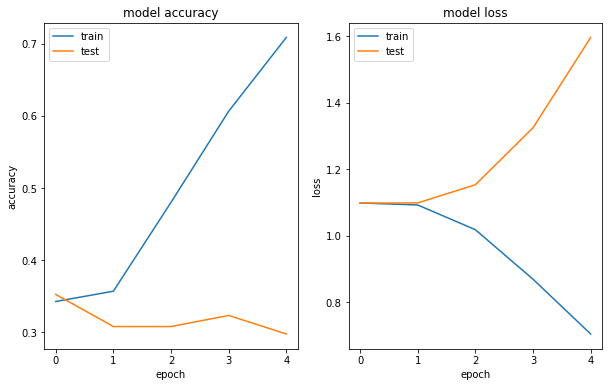

In [42]:
plt.figure(figsize = (10,6))

# summarize history for accuracy

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

## Fitting on other languages

In [38]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(padded_train_eng,y_train_eng, epochs = 5, validation_split = 0.1)

Epoch 1/5
165/165 [==============================] - 4s 26ms/step - loss: 1.0986 - accuracy: 0.3437 - val_loss: 1.0976 - val_accuracy: 0.3527
Epoch 2/5
165/165 [==============================] - 5s 31ms/step - loss: 1.0912 - accuracy: 0.3846 - val_loss: 1.1067 - val_accuracy: 0.3185
Epoch 3/5
165/165 [==============================] - 4s 22ms/step - loss: 1.0056 - accuracy: 0.5069 - val_loss: 1.1652 - val_accuracy: 0.3271
Epoch 4/5
165/165 [==============================] - 4s 22ms/step - loss: 0.8110 - accuracy: 0.6542 - val_loss: 1.4203 - val_accuracy: 0.3219
Epoch 5/5
165/165 [==============================] - 4s 24ms/step - loss: 0.6322 - accuracy: 0.7456 - val_loss: 1.7581 - val_accuracy: 0.3168


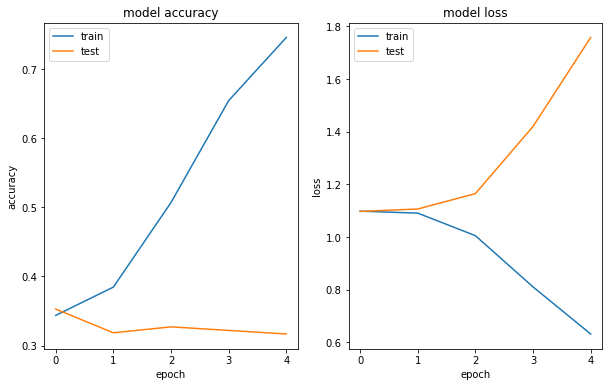

In [39]:
plt.figure(figsize = (10,6))

# summarize history for accuracy

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
prediction = model.predict_classes(padded_test)
prediction

In [85]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
print("Accuracy", accuracy_score(y_test, prediction))
print("Confusion Matrix", confusion_matrix(y_test, prediction))
print("Classification Report", classification_report(y_test, prediction))

### Training a Bi-directional LSTM model

In [43]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, output_dim=emb_dim, input_length=max_len))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,)))
model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 32)           320000    
_________________________________________________________________
bidirectional (Bidirectional (None, 250, 32)           6272      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                16640     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 3)                

### Fitting on English dataset

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(padded_train_eng,y_train_eng, epochs = 5, validation_split = 0.1)

Epoch 1/5
165/165 [==============================] - 7s 45ms/step - loss: 1.0984 - accuracy: 0.3347 - val_loss: 1.0980 - val_accuracy: 0.3527
Epoch 2/5
165/165 [==============================] - 7s 39ms/step - loss: 1.0871 - accuracy: 0.3798 - val_loss: 1.0778 - val_accuracy: 0.4229
Epoch 3/5
165/165 [==============================] - 8s 47ms/step - loss: 0.9939 - accuracy: 0.5069 - val_loss: 1.1694 - val_accuracy: 0.3373
Epoch 4/5
165/165 [==============================] - 6s 39ms/step - loss: 0.8147 - accuracy: 0.6362 - val_loss: 1.4324 - val_accuracy: 0.3305
Epoch 5/5
165/165 [==============================] - 6s 39ms/step - loss: 0.6391 - accuracy: 0.7399 - val_loss: 1.5680 - val_accuracy: 0.3288


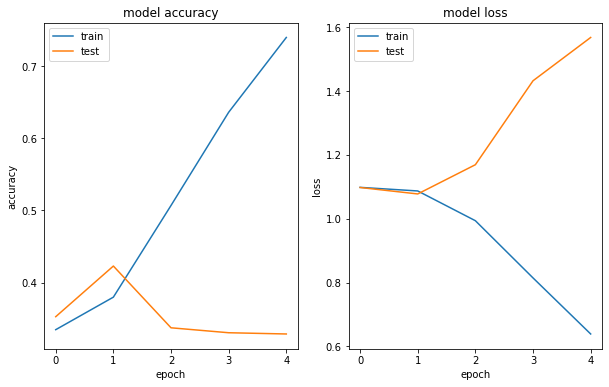

In [45]:
plt.figure(figsize = (10,6))

# summarize history for accuracy

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [46]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(padded_train_other,y_train_other, epochs = 5, validation_split = 0.1)

Epoch 1/5
126/126 [==============================] - 6s 50ms/step - loss: 1.1183 - accuracy: 0.3402 - val_loss: 1.0968 - val_accuracy: 0.3624
Epoch 2/5
126/126 [==============================] - 5s 38ms/step - loss: 1.0979 - accuracy: 0.3415 - val_loss: 1.0972 - val_accuracy: 0.3803
Epoch 3/5
126/126 [==============================] - 6s 48ms/step - loss: 1.0907 - accuracy: 0.3539 - val_loss: 1.1013 - val_accuracy: 0.3870
Epoch 4/5
126/126 [==============================] - 5s 39ms/step - loss: 1.0656 - accuracy: 0.3893 - val_loss: 1.1132 - val_accuracy: 0.3490
Epoch 5/5
126/126 [==============================] - 5s 40ms/step - loss: 0.9956 - accuracy: 0.4438 - val_loss: 1.1533 - val_accuracy: 0.3221


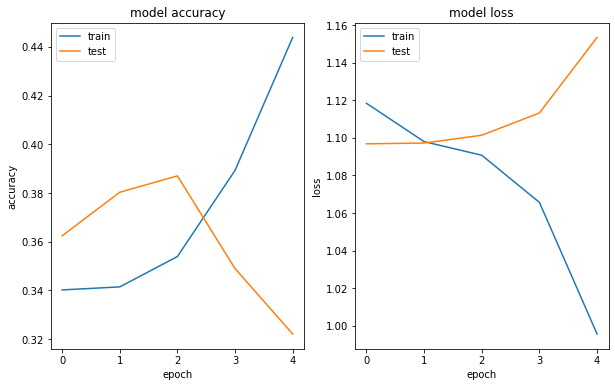

In [47]:
plt.figure(figsize = (10,6))

# summarize history for accuracy

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
prediction = model.predict_classes(padded_test)
prediction

In [ ]:
print("Accuracy", accuracy_score(y_test, prediction))
print("Confusion Matrix", confusion_matrix(y_test, prediction))
print("Classification Report", classification_report(y_test, prediction))

### Training a base BERT model

In [48]:
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)

Tokenizers are used to convert the text into numbers

In [49]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

In [50]:
encode_sentence("This is my NLP project")

[10747, 10124, 15127, 81130, 11127, 13920, 102]

#### Data Preparation

BERT uses three kind of input data- input word IDs, input masks, and input type IDs.

These allow the model to know that the premise and hypothesis are distinct sentences, and also to ignore any padding from the tokenizer.

We add a [CLS] token to denote the beginning of the inputs, and a [SEP] token to denote the separation between the premise and the hypothesis. We also need to pad all of the inputs to be the same size. 

Now, we're going to encode all of our premise/hypothesis pairs for input into BERT.

In [51]:
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [ ]:
y = train_df['label']
X = train_df.drop(['label'], axis = 1)

In [ ]:
bert_encode(['This is my NLP Project'],['This is not my NLP Project'],tokenizer)

In [52]:
X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, y_eng, test_size=0.15, random_state=0)
X_train_other, X_test_other, y_train_other, y_test_other = train_test_split(X_other, y_other, test_size=0.15, random_state=0)

In [53]:
train_input_eng = bert_encode(X_train_eng.premise.values,X_train_eng.hypothesis,tokenizer)
train_input_other = bert_encode(X_train_other.premise.values,X_train_other.hypothesis,tokenizer)

#### Building the model

In [55]:

def build_model(model_name, max_len):
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    embedding = bert_encoder([input_word_ids, input_mask, input_type_ids])[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [56]:
model = build_model(model_name, max_len = 50)
model.summary()

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 50)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 50)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 50, 768), (N 177853440   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

In [ ]:
y_train.shape

### Fitting the english version

In [57]:
history = model.fit(train_input_eng, y_train_eng, epochs = 2, verbose = 1, validation_split = 0.1)

Epoch 1/2
165/165 [==============================] - 75s 457ms/step - loss: 1.0493 - accuracy: 0.4466 - val_loss: 0.9698 - val_accuracy: 0.5325
Epoch 2/2
165/165 [==============================] - 72s 437ms/step - loss: 0.9341 - accuracy: 0.5465 - val_loss: 0.9681 - val_accuracy: 0.5565


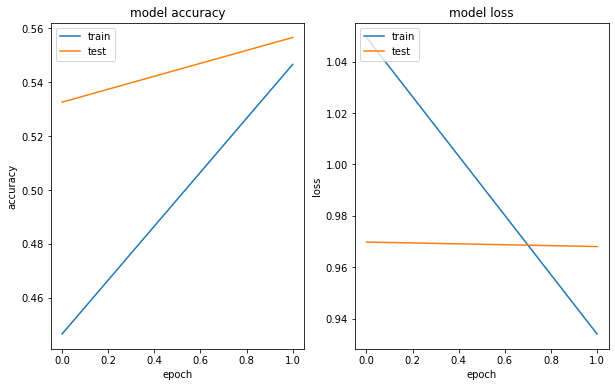

In [58]:
plt.figure(figsize = (10,6))

# summarize history for accuracy

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

### Fitting other languages data

In [61]:
history = model.fit(train_input_other, y_train_other, epochs = 5, verbose = 1, validation_split = 0.1)

Epoch 1/5
126/126 [==============================] - 49s 386ms/step - loss: 0.9379 - accuracy: 0.4959 - val_loss: 1.0955 - val_accuracy: 0.4027
Epoch 2/5
126/126 [==============================] - 48s 384ms/step - loss: 0.8462 - accuracy: 0.5425 - val_loss: 1.2368 - val_accuracy: 0.3826
Epoch 3/5
126/126 [==============================] - 48s 384ms/step - loss: 0.7768 - accuracy: 0.5743 - val_loss: 1.3396 - val_accuracy: 0.4206
Epoch 4/5
126/126 [==============================] - 48s 384ms/step - loss: 0.7219 - accuracy: 0.6005 - val_loss: 1.5419 - val_accuracy: 0.3669
Epoch 5/5
126/126 [==============================] - 48s 383ms/step - loss: 0.6757 - accuracy: 0.6276 - val_loss: 1.8616 - val_accuracy: 0.3915


In [67]:
train_input_other.keys()

train_

dict_keys(['input_word_ids', 'input_mask', 'input_type_ids'])

### Fitting a Logistic Regression on Bert encodings

In [71]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(padded_train_other,y_train_other)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [83]:
y_pred = lr.predict(padded_test_other)

In [86]:
print("Accuracy", accuracy_score(y_test_other, y_pred))
print("Confusion Matrix", confusion_matrix(y_test_other, y_pred))
print("Classification Report", classification_report(y_test_other, y_pred))

Accuracy 0.3236040609137056
Confusion Matrix [[ 59 156  39]
 [ 66 142  40]
 [ 62 170  54]]
Classification Report               precision    recall  f1-score   support

           0       0.32      0.23      0.27       254
           1       0.30      0.57      0.40       248
           2       0.41      0.19      0.26       286

    accuracy                           0.32       788
   macro avg       0.34      0.33      0.31       788
weighted avg       0.34      0.32      0.30       788



In [88]:
lr.fit(padded_train_eng,y_train_eng)
y_pred = lr.predict(padded_test_eng)
print("Accuracy", accuracy_score(y_test_eng, y_pred))
print("Confusion Matrix", confusion_matrix(y_test_eng, y_pred))
print("Classification Report", classification_report(y_test_eng, y_pred))

Accuracy 0.3443258971871969
Confusion Matrix [[236  60  68]
 [189  58  68]
 [235  56  61]]
Classification Report               precision    recall  f1-score   support

           0       0.36      0.65      0.46       364
           1       0.33      0.18      0.24       315
           2       0.31      0.17      0.22       352

    accuracy                           0.34      1031
   macro avg       0.33      0.34      0.31      1031
weighted avg       0.33      0.34      0.31      1031



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


### Fitting a decision tree model

In [87]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

dt.fit(padded_train_eng, y_train_eng)

y_pred = dt.predict(padded_test_eng)

print("Accuracy", accuracy_score(y_test_eng, y_pred))
print("Confusion Matrix", confusion_matrix(y_test_eng, y_pred))
print("Classification Report", classification_report(y_test_eng, y_pred))

Accuracy 0.3239573229873909
Confusion Matrix [[125 135 104]
 [103 112 100]
 [115 140  97]]
Classification Report               precision    recall  f1-score   support

           0       0.36      0.34      0.35       364
           1       0.29      0.36      0.32       315
           2       0.32      0.28      0.30       352

    accuracy                           0.32      1031
   macro avg       0.33      0.32      0.32      1031
weighted avg       0.33      0.32      0.32      1031



In [ ]:
dt.fit(padded_train_other, y_train_other)

y_pred = dt.predict(padded_test_other)

print("Accuracy", accuracy_score(y_test_other, y_pred))
print("Confusion Matrix", confusion_matrix(y_test_other, y_pred))
print("Classification Report", classification_report(y_test_other, y_pred))

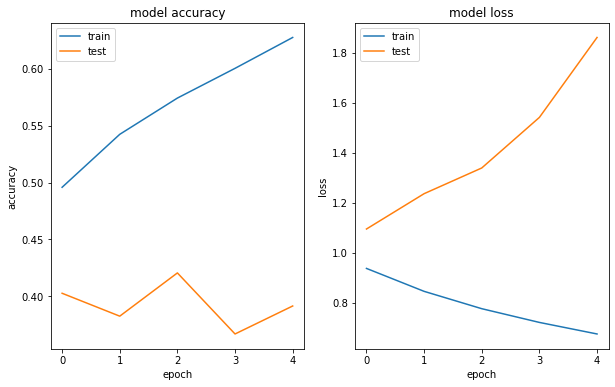

In [62]:
plt.figure(figsize = (10,6))

# summarize history for accuracy

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
X_test.hypothesis.values

In [ ]:
X_test.premise.values

In [ ]:
model_name = 'roberta-base'

model = build_model(model_name, max_len = 50)
model.summary()

In [ ]:
history = model.fit(train_input, y_train, epochs = 2, verbose = 1, validation_split = 0.1)

In [ ]:
plt.figure(figsize = (16,6))

# summarize history for accuracy

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')


plt.subplot(1,2,2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [ ]:
#test_input = bert_encode(test_df.premise.values, test_df.hypothesis.values, tokenizer)

In [ ]:
#predictions = [np.argmax(i) for i in model.predict(test_input)]

In [ ]:

# import pandas as pd

# df_submission = pd.DataFrame({"id": test_df.id.values, "prediction": predictions})
# df_submission.to_csv("submission.csv", index = False)

# df_submission.prediction.value_counts()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
print("Accuracy", accuracy_score(y_test, predictions))
print("Confusion Matrix", confusion_matrix(y_test, predictions))
print("Classification Report", classification_report(y_test, predictions))

In [ ]:
bert_input = bert_encode(['000000000000000000000000000000000000000000000000000000 Killing someone 00000000000000000000'], ['000000000000000000000000000 Never kill anyone 000000000000000000000000'], tokenizer)

In [ ]:
bert_input

In [ ]:
np.argmax(model.predict(bert_input))

In [ ]:
predict_burt

### Training a XLNet Base Cased

In [ ]:
#!pip install googletrans

In [ ]:
#from googletrans import Translator

In [ ]:

#In general, the idea is to expand on this configuration as you progress through a competition with more ideas and elements to experiment on.

## defining configuration
class Configuration():
    """
    All configuration for running an experiment
    """
    def __init__(
        self,
        model_name,
        translation = False,
        max_length = 64,
        padding = True,
        batch_size = 128,
        epochs = 5,
        learning_rate = 1e-5,
        metrics = ["sparse_categorical_accuracy"],
        verbose = 1,
        train_splits = 5,
        accelerator = "TPU",
        myluckynumber = 13
    ):
        # seed and accelerator
        self.SEED = 100
        self.ACCELERATOR = accelerator

        # paths
        self.PATH_TRAIN = train_df
        self.PATH_TEST  = test_df

        # splits
        self.TRAIN_SPLITS = train_splits

        # mapping of language
        self.LANGUAGE_MAP = {
            "English"   : 0,
            "Chinese"   : 1,
            "Arabic"    : 2,
            "French"    : 3,
            "Swahili"   : 4,
            "Urdu"      : 5,
            "Vietnamese": 6,
            "Russian"   : 7,
            "Hindi"     : 8,
            "Greek"     : 9,
            "Thai"      : 10,
            "Spanish"   : 11,
            "German"    : 12,
            "Turkish"   : 13,
            "Bulgarian" : 14
        }

        self.INVERSE_LANGUAGE_MAP = {v: k for k, v in self.LANGUAGE_MAP.items()}

        # model configuration
        self.MODEL_NAME = model_name
        self.TRANSLATION = translation
        self.TOKENIZER = AutoTokenizer.from_pretrained(self.MODEL_NAME)

        # model hyperparameters
        self.MAX_LENGTH = max_length
        self.PAD_TO_MAX_LENGTH = padding
        self.BATCH_SIZE = batch_size
        self.EPOCHS = epochs
        self.LEARNING_RATE = learning_rate
        self.METRICS = metrics
        self.VERBOSE = verbose
        
        # initializing accelerator
        self.initialize_accelerator()

    def initialize_accelerator(self):
        """
        Initializing accelerator
        """
        # checking TPU first
        if self.ACCELERATOR == "TPU":
            print("Connecting to TPU")
            try:
                tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
                print(f"Running on TPU {tpu.master()}")
            except ValueError:
                print("Could not connect to TPU")
                tpu = None

            if tpu:
                try:
                    print("Initializing TPU")
                    tf.config.experimental_connect_to_cluster(tpu)
                    tf.tpu.experimental.initialize_tpu_system(tpu)
                    self.strategy = tf.distribute.experimental.TPUStrategy(tpu)
                    self.tpu = tpu
                    print("TPU initialized")
                except _:
                    print("Failed to initialize TPU")
            else:
                print("Unable to initialize TPU")
                self.ACCELERATOR = "GPU"

        # default for CPU and GPU
        if self.ACCELERATOR != "TPU":
            print("Using default strategy for CPU and single GPU")
            self.strategy = tf.distribute.get_strategy()

        # checking GPUs
        if self.ACCELERATOR == "GPU":
            print(f"GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")

        # defining replicas
        self.AUTO = tf.data.experimental.AUTOTUNE
        self.REPLICAS = self.strategy.num_replicas_in_sync
        print(f"REPLICAS: {self.REPLICAS}")

In [ ]:
## data preparation functions
def translate_text_to_english(text):
    """
    Translates text to English.
    """
    translator = Translator()

    return translator.translate(text, dest = "en").text


def encode_text(df, tokenizer, max_len, padding):
    """
    Preprocessing textual data into encoded tokens.
    """
    text = df[["premise", "hypothesis"]].values.tolist()

    # encoding text using tokenizer of the model
    text_encoded = tokenizer.batch_encode_plus(
        text,
        pad_to_max_length = padding,
        max_length = max_len
    )

    return text_encoded


def get_tf_dataset(X, y, auto, labelled = True, repeat = False, shuffle = False, batch_size = 128):
    """
    Creating tf.data.Dataset for TPU.
    """
    if labelled:
        ds = (tf.data.Dataset.from_tensor_slices((X["input_ids"], y)))
    else:
        ds = (tf.data.Dataset.from_tensor_slices(X["input_ids"]))

    if repeat:
        ds = ds.repeat()

    if shuffle:
        ds = ds.shuffle(2048)

    ds = ds.batch(batch_size)
    ds = ds.prefetch(auto)

    return ds

In [ ]:
## building model
def build_model(model_name, max_len, learning_rate, metrics):
    """
    Building the Deep Learning architecture
    """
    # defining encoded inputs
    input_ids = Input(shape = (max_len,), dtype = tf.int32, name = "input_ids")
    
    # defining transformer model embeddings
    transformer_model = TFAutoModel.from_pretrained(model_name)
    transformer_embeddings = transformer_model(input_ids)[0]
    
    # defining output layer
    
    output_values = Dense(3, activation = "softmax")(transformer_embeddings[:, 0, :])

    # defining model
    model = Model(inputs = input_ids, outputs = output_values)
    opt = Adam(learning_rate = learning_rate)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
    metrics = metrics

    model.compile(optimizer = opt, loss = loss, metrics = metrics)

    return model

In [ ]:
## stratified k-fold over language and label
def run_model(config):
    """
    Running the model
    """
    ## reading data
    df_train = train_df
    df_test = test_df
    
    # translating non-English text to English
    if config.TRANSLATION:
        df_train.loc[df_train.language != "English", "premise"] = df_train[df_train.language != "English"].premise.apply(lambda x: translate_text_to_english(x))
        df_test.loc[df_test.language != "English", "premise"] = df_test[df_test.language != "English"].premise.apply(lambda x: translate_text_to_english(x))

        df_train.loc[df_train.language != "English", "hypothesis"] = df_train[df_train.language != "English"].hypothesis.apply(lambda x: translate_text_to_english(x))
        df_test.loc[df_test.language != "English", "hypothesis"] = df_test[df_test.language != "English"].hypothesis.apply(lambda x: translate_text_to_english(x))

    # adding column for stratified splitting
    df_train["language_label"] = df_train.language.astype(str) + "_" + df_train.label.astype(str)

    # stratified K-fold on language and label
    skf = StratifiedKFold(n_splits = config.TRAIN_SPLITS, shuffle = True, random_state = config.SEED)

    # initializing predictions
    preds_oof = np.zeros((df_train.shape[0], 3))
    preds_test = np.zeros((df_test.shape[0], 3))
    acc_oof = []

    # iterating over folds
    for (fold, (train_index, valid_index)) in enumerate(skf.split(df_train, df_train.language_label)):
        # initializing TPU
        if config.ACCELERATOR == "TPU":
            if config.tpu:
                config.initialize_accelerator()

        # building model
        #K.clear_session()
        with config.strategy.scope():
            model = build_model(config.MODEL_NAME, config.MAX_LENGTH, config.LEARNING_RATE, config.METRICS)
            if fold == 0:
                print(model.summary())

        print("\n")
        print("#" * 19)
        print(f"##### Fold: {fold + 1} #####")
        print("#" * 19)

        # splitting data into training and validation
        X_train = df_train.iloc[train_index]
        X_valid = df_train.iloc[valid_index]

        y_train = X_train.label.values
        y_valid = X_valid.label.values

        print("\nTokenizing")

        # encoding text data using tokenizer
        X_train_encoded = encode_text(df = X_train, tokenizer = config.TOKENIZER, max_len = config.MAX_LENGTH, padding = config.PAD_TO_MAX_LENGTH)
        X_valid_encoded = encode_text(df = X_valid, tokenizer = config.TOKENIZER, max_len = config.MAX_LENGTH, padding = config.PAD_TO_MAX_LENGTH)

        # creating TF Dataset
        ds_train = get_tf_dataset(X_train_encoded, y_train, config.AUTO, repeat = True, shuffle = True, batch_size = config.BATCH_SIZE * config.REPLICAS)
        ds_valid = get_tf_dataset(X_valid_encoded, y_valid, config.AUTO, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)

        n_train = X_train.shape[0]

        if fold == 0:
            X_test_encoded = encode_text(df = df_test, tokenizer = config.TOKENIZER, max_len = config.MAX_LENGTH, padding = config.PAD_TO_MAX_LENGTH)

        # saving model at best accuracy epoch
        sv = tf.keras.callbacks.ModelCheckpoint(
            "model.h5",
            monitor = "val_sparse_categorical_accuracy",
            verbose = 0,
            save_best_only = True,
            save_weights_only = True,
            mode = "max",
            save_freq = "epoch"
        )

        print("\nTraining")

        # training model
        model_history = model.fit(
            ds_train,
            epochs = config.EPOCHS,
            callbacks = [sv],
            steps_per_epoch = n_train / config.BATCH_SIZE // config.REPLICAS,
            validation_data = ds_valid,
            verbose = config.VERBOSE
        )
        
        plt.figure(figsize = (16,6))

    # summarize history for accuracy

        plt.subplot(1,2,1)
        plt.plot(model_history.history['sparse_categorical_accuracy'])
        plt.plot(model_history.history['val_sparse_categorical_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')


        plt.subplot(1,2,2)
        # summarize history for loss
        plt.plot(model_history.history['loss'])
        plt.plot(model_history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')

        plt.show()
        
        

        print("\nValidating")

        # scoring validation data
        model.load_weights("model.h5")
        ds_valid = get_tf_dataset(X_valid_encoded, -1, config.AUTO, labelled = False, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)

        preds_valid = model.predict(ds_valid, verbose = config.VERBOSE)
        acc = accuracy_score(y_valid, np.argmax(preds_valid, axis = 1))

        preds_oof[valid_index] = preds_valid
        acc_oof.append(acc)

        print("\nInferencing")

        # scoring test data
        ds_test = get_tf_dataset(X_test_encoded, -1, config.AUTO, labelled = False, batch_size = config.BATCH_SIZE * config.REPLICAS * 4)
        preds_test += model.predict(ds_test, verbose = config.VERBOSE) / config.TRAIN_SPLITS

        print(f"\nFold {fold + 1} Accuracy: {round(acc, 4)}\n")

        #g = gc.collect()

    # overall CV score and standard deviation
    print(f"\nCV Mean Accuracy: {round(np.mean(acc_oof), 4)}")
    print(f"CV StdDev Accuracy: {round(np.std(acc_oof), 4)}\n")

    return preds_oof, preds_test

In [ ]:
# # Model: Bert Base Cased
# config_1 = Configuration("bert-base-cased", max_length = 32, batch_size = 32, epochs = 2, train_splits = 2)
# preds_train_1, preds_test_1 = run_model(config_1)

In [ ]:
# # Model: Distilbert Multilingual Base Cased
# config_2 = Configuration("distilbert-base-multilingual-cased", translation = False, max_length = 50, batch_size = 32, epochs = 5, train_splits = 2)
# preds_train_2,preds_test_2 = run_model(config_2)

In [ ]:
# # Model: XLNet Base Cased
# config_3 = Configuration("xlnet-base-cased", max_length = 50, batch_size = 32, epochs = 2, train_splits = 2)
# preds_train_3 = run_model(config_3)

In [ ]:
# # Model: XLM Roberta Base
# config_4 = Configuration("roberta-base", translation = False, max_length = 84, batch_size = 64, epochs = 5, train_splits = 2)
# preds_train_4, preds_test_4 = run_model(config_4)

Submitting in the competition

In [ ]:

# import pandas as pd

# df_submission = pd.DataFrame({"id": test_df.id.values, "prediction": np.argmax(preds_test_2, axis = 1)})
# df_submission.to_csv("submission.csv", index = False)

# df_submission.prediction.value_counts()